In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/corona-virus-report/covid_19_clean_complete.csv
/kaggle/input/corona-virus-report/country_wise_latest.csv
/kaggle/input/corona-virus-report/day_wise.csv
/kaggle/input/corona-virus-report/usa_county_wise.csv
/kaggle/input/corona-virus-report/worldometer_data.csv
/kaggle/input/corona-virus-report/full_grouped.csv


In [2]:
country_wise_df = pd.read_csv('/kaggle/input/corona-virus-report/country_wise_latest.csv')

In [3]:
country_wise_df.columns

Index(['Country/Region', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'New cases', 'New deaths', 'New recovered', 'Deaths / 100 Cases',
       'Recovered / 100 Cases', 'Deaths / 100 Recovered',
       'Confirmed last week', '1 week change', '1 week % increase',
       'WHO Region'],
      dtype='object')

In [4]:
country_wise_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country/Region          187 non-null    object 
 1   Confirmed               187 non-null    int64  
 2   Deaths                  187 non-null    int64  
 3   Recovered               187 non-null    int64  
 4   Active                  187 non-null    int64  
 5   New cases               187 non-null    int64  
 6   New deaths              187 non-null    int64  
 7   New recovered           187 non-null    int64  
 8   Deaths / 100 Cases      187 non-null    float64
 9   Recovered / 100 Cases   187 non-null    float64
 10  Deaths / 100 Recovered  187 non-null    float64
 11  Confirmed last week     187 non-null    int64  
 12  1 week change           187 non-null    int64  
 13  1 week % increase       187 non-null    float64
 14  WHO Region              187 non-null    ob

In [5]:
country_wise_df.describe()

/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,Confirmed last week,1 week change,1 week % increase
count,1.870000e+02,187.000000,1.870000e+02,1.870000e+02,187.000000,187.000000,187.000000,187.000000,187.000000,187.00,1.870000e+02,187.000000,187.000000
mean,8.813094e+04,3497.518717,5.063148e+04,3.400194e+04,1222.957219,28.957219,933.812834,3.019519,64.820535,inf,7.868248e+04,9448.459893,13.606203
std,3.833187e+05,14100.002482,1.901882e+05,2.133262e+05,5710.374790,120.037173,4197.719635,3.454302,26.287694,NaN,3.382737e+05,47491.127684,24.509838
min,1.000000e+01,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,1.000000e+01,-47.000000,-3.840000
25%,1.114000e+03,18.500000,6.265000e+02,1.415000e+02,4.000000,0.000000,0.000000,0.945000,48.770000,1.45,1.051500e+03,49.000000,2.775000
50%,5.059000e+03,108.000000,2.815000e+03,1.600000e+03,49.000000,1.000000,22.000000,2.150000,71.320000,3.62,5.020000e+03,432.000000,6.890000
75%,4.046050e+04,734.000000,2.260600e+04,9.149000e+03,419.500000,6.000000,221.000000,3.875000,86.885000,6.44,3.708050e+04,3172.000000,16.855000
max,4.290259e+06,148011.000000,1.846641e+06,2.816444e+06,56336.000000,1076.000000,33728.000000,28.560000,100.000000,inf,3.834677e+06,455582.000000,226.320000


from previous statistics measurements we will find out that there are outliers in most of these columns 
let's start with ploting them 
then calculating the IQR and apply Winsorizing

In [6]:
def calculating_iqr(column):
    q1 = country_wise_df[column].quantile(0.25)
    q3 = country_wise_df[column].quantile(0.75)
    q2 = q3 - q1
    upper = q3 + (1.5 * q2)
    lower = q1 - (1.5 * q1)
    return lower,upper

In [7]:
handle_outliers = lambda x: lower if x < lower else(upper if x > upper else x)

Handling outliers in numerical colums

In [8]:
col = [['Confirmed', 'Deaths','Recovered', 'Active'],[
       'New cases', 'New deaths', 'New recovered'],[ 'Deaths / 100 Cases',
       'Recovered / 100 Cases', 'Deaths / 100 Recovered'],[
       'Confirmed last week', '1 week change', '1 week % increase']]

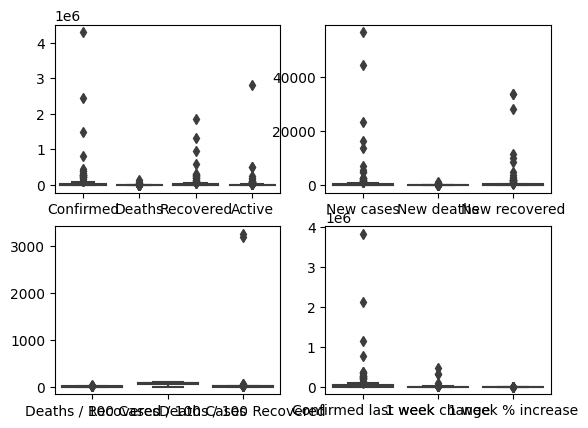

In [9]:
plt.subplot(2,2,1)
sns.boxplot(data= country_wise_df[col[0]])

plt.subplot(2,2,2)
sns.boxplot(data= country_wise_df[col[1]])

plt.subplot(2,2,3)
sns.boxplot(data= country_wise_df[col[2]])

plt.subplot(2,2,4)
sns.boxplot(data= country_wise_df[col[3]])
plt.show()

##### Handling outliers in columns:  'Confirmed', 'Deaths','Recovered', 'Active'

In [10]:
# confirmed column
lower,upper = calculating_iqr('Confirmed')
country_wise_df['Confirmed'] = country_wise_df['Confirmed'].apply(handle_outliers)

# Deaths column
lower,upper = calculating_iqr('Deaths')
country_wise_df['Deaths'] = country_wise_df['Deaths'].apply(handle_outliers)

# 'Recovered' column
lower,upper = calculating_iqr('Recovered')
country_wise_df['Recovered'] = country_wise_df['Recovered'].apply(handle_outliers)

# 'Active' column
lower,upper = calculating_iqr('Active')
country_wise_df['Active'] = country_wise_df['Active'].apply(handle_outliers)

In [11]:
# Handling 'New cases' column
lower,upper = calculating_iqr('New cases')
country_wise_df['New cases'] = country_wise_df['New cases'].apply(handle_outliers)

# Handling 'New deaths' column
lower,upper = calculating_iqr('New deaths')
country_wise_df['New deaths'] = country_wise_df['New deaths'].apply(handle_outliers)

# Handling 'New recovered' column
lower,upper = calculating_iqr('New recovered')
country_wise_df['New recovered'] = country_wise_df['New recovered'].apply(handle_outliers)

In [12]:
# 'Deaths / 100 Cases' column
lower,upper = calculating_iqr('Deaths / 100 Cases')
country_wise_df['Deaths / 100 Cases'] = country_wise_df['Deaths / 100 Cases'].apply(handle_outliers)
# 'Recovered / 100 Cases' column
lower,upper = calculating_iqr('Recovered / 100 Cases')
country_wise_df['Recovered / 100 Cases'] = country_wise_df['Recovered / 100 Cases'].apply(handle_outliers)
# 'Deaths / 100 Recovered' column
lower,upper = calculating_iqr('Deaths / 100 Recovered')
country_wise_df['Deaths / 100 Recovered'] = country_wise_df['Deaths / 100 Recovered'].apply(handle_outliers)

In [13]:
# 'Confirmed last week' column
lower,upper = calculating_iqr('Confirmed last week')
country_wise_df['Confirmed last week'] = country_wise_df['Confirmed last week'].apply(handle_outliers)

# '1 week change' column
lower,upper = calculating_iqr('1 week change')
country_wise_df['1 week change'] = country_wise_df['1 week change'].apply(handle_outliers)

# '1 week % increase' column
lower,upper = calculating_iqr('1 week % increase')
country_wise_df['1 week % increase'] = country_wise_df['1 week % increase'].apply(handle_outliers)

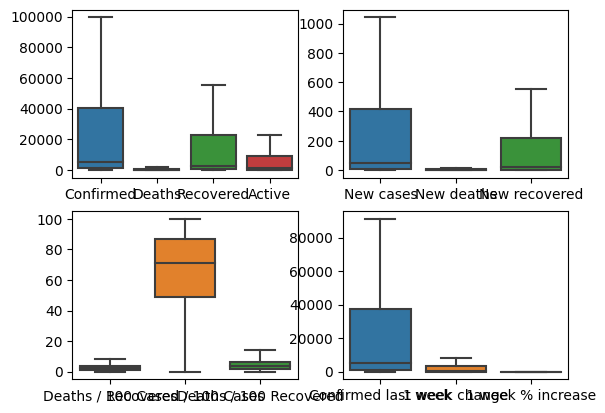

In [14]:
# Ploting after handling outliers
plt.subplot(2,2,1)
sns.boxplot(data= country_wise_df[col[0]])

plt.subplot(2,2,2)
sns.boxplot(data= country_wise_df[col[1]])

plt.subplot(2,2,3)
sns.boxplot(data= country_wise_df[col[2]])

plt.subplot(2,2,4)
sns.boxplot(data= country_wise_df[col[3]])
plt.show()

In [15]:
country_wise_df.describe()

,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,Confirmed last week,1 week change,1 week % increase
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,25944.139037,510.172460,14132.883690,6266.176471,264.544118,3.802139,144.483957,2.697005,64.820535,4.768289,23604.331551,2022.804813,11.167340
std,35481.834416,700.605387,19846.563715,8514.912668,366.343842,5.496665,205.116423,2.255514,26.287694,4.249337,32536.210181,2773.893022,10.918431
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,-24.500000,-1.387500
25%,1114.000000,18.500000,626.500000,141.500000,4.000000,0.000000,0.000000,0.945000,48.770000,1.450000,1051.500000,49.000000,2.775000
50%,5059.000000,108.000000,2815.000000,1600.000000,49.000000,1.000000,22.000000,2.150000,71.320000,3.620000,5020.000000,432.000000,6.890000
75%,40460.500000,734.000000,22606.000000,9149.000000,419.500000,6.000000,221.000000,3.875000,86.885000,6.440000,37080.500000,3172.000000,16.855000
max,99480.250000,1807.250000,55575.250000,22660.250000,1042.750000,15.000000,552.500000,8.270000,100.000000,13.925000,91124.000000,7856.500000,37.975000


In [16]:
country_wise_df['Total cases'] = country_wise_df['Confirmed'] + country_wise_df['New cases']

In [17]:
country_wise_df['Total deaths'] = country_wise_df['Deaths'] + country_wise_df['New deaths']


In [18]:
country_wise_df['Total recovered'] = country_wise_df['Recovered'] + country_wise_df['New recovered']

In [19]:
country_wise_df['Total active'] = country_wise_df['Total cases'] - (country_wise_df['Total deaths'] + country_wise_df['Total recovered'])

In [20]:
country_wise_df['Active / 100 Cases'] = 100 - ( country_wise_df['Deaths / 100 Cases'] + country_wise_df['Recovered / 100 Cases'])

In [21]:
country_wise_df.head()

,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,Confirmed last week,1 week change,1 week % increase,WHO Region,Total cases,Total deaths,Total recovered,Total active,Active / 100 Cases
0,Afghanistan,36263.0,1269.0,25198.0,9796.0,106.0,10.0,18.0,3.50,69.49,5.040,35526.0,737.0,2.07,Eastern Mediterranean,36369.0,1279.0,25216.0,9874.0,27.01
1,Albania,4880.0,144.0,2745.0,1991.0,117.0,6.0,63.0,2.95,56.25,5.250,4171.0,709.0,17.00,Europe,4997.0,150.0,2808.0,2039.0,40.80
2,Algeria,27973.0,1163.0,18837.0,7973.0,616.0,8.0,552.5,4.16,67.34,6.170,23691.0,4282.0,18.07,Africa,28589.0,1171.0,19389.5,8028.5,28.50
3,Andorra,907.0,52.0,803.0,52.0,10.0,0.0,0.0,5.73,88.53,6.480,884.0,23.0,2.60,Europe,917.0,52.0,803.0,62.0,5.74
4,Angola,950.0,41.0,242.0,667.0,18.0,1.0,0.0,4.32,25.47,13.925,749.0,201.0,26.84,Africa,968.0,42.0,242.0,684.0,70.21


In [22]:
len(country_wise_df['Country/Region'].unique())

187

In [23]:
n_country_WHO = country_wise_df.groupby('WHO Region')['Country/Region'].count()
n_country_WHO

WHO Region
Africa                   48
Americas                 35
Eastern Mediterranean    22
Europe                   56
South-East Asia          10
Western Pacific          16
Name: Country/Region, dtype: int64

In [24]:
who_reg_val = country_wise_df['WHO Region'].unique()
who_reg_val

array(['Eastern Mediterranean', 'Europe', 'Africa', 'Americas',
       'Western Pacific', 'South-East Asia'], dtype=object)

In [25]:
max_countries_in_active_in_each_who_region = country_wise_df.groupby('WHO Region')['Country/Region'].agg({max_death := ('Total deaths',"max"), max_confirmed := ('Total cases','max'),max_recovered := ('Total recovered','max')})
max_countries_in_active_in_each_who_region

,Total cases,Total recovered,Total deaths
WHO Region,,,
Africa,Zimbabwe,Zimbabwe,Zimbabwe
Americas,Venezuela,Venezuela,Venezuela
Eastern Mediterranean,Yemen,Yemen,Yemen
Europe,Uzbekistan,Uzbekistan,Uzbekistan
South-East Asia,Timor-Leste,Timor-Leste,Timor-Leste
Western Pacific,Vietnam,Vietnam,Vietnam


In [26]:
max_countries_in_active_in_each_who_region_per = country_wise_df.groupby('WHO Region')['Country/Region'].agg({max_death_100_cases := ('Deaths / 100 Cases country',"max"), max_recover_100_cases := ('Recovered / 100 Cases country','max'),max_death_for_100_recover := ('Deaths / 100 Recovered country','max')})
max_countries_in_active_in_each_who_region_per

,Deaths / 100 Recovered country,Deaths / 100 Cases country,Recovered / 100 Cases country
WHO Region,,,
Africa,Zimbabwe,Zimbabwe,Zimbabwe
Americas,Venezuela,Venezuela,Venezuela
Eastern Mediterranean,Yemen,Yemen,Yemen
Europe,Uzbekistan,Uzbekistan,Uzbekistan
South-East Asia,Timor-Leste,Timor-Leste,Timor-Leste
Western Pacific,Vietnam,Vietnam,Vietnam


from this analysis we will find that for each 100 cases maximum values for each country in each WHO Region will be the same if they are compared between all cases without percentage

In [27]:
country_wise_df.columns

Index(['Country/Region', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'New cases', 'New deaths', 'New recovered', 'Deaths / 100 Cases',
       'Recovered / 100 Cases', 'Deaths / 100 Recovered',
       'Confirmed last week', '1 week change', '1 week % increase',
       'WHO Region', 'Total cases', 'Total deaths', 'Total recovered',
       'Total active', 'Active / 100 Cases'],
      dtype='object')

In [28]:
country_wise_df[['Deaths / 100 Cases','Recovered / 100 Cases', 'Deaths / 100 Recovered','Confirmed last week', '1 week change', '1 week % increase', 'Total cases', 'Total deaths', 'Total recovered','Total active', 'Active / 100 Cases']].describe()

,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,Confirmed last week,1 week change,1 week % increase,Total cases,Total deaths,Total recovered,Total active,Active / 100 Cases
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,2.697005,64.820535,4.768289,23604.331551,2022.804813,11.167340,26208.683155,513.974599,14277.367647,11417.340909,32.482460
std,2.255514,26.287694,4.249337,32536.210181,2773.893022,10.918431,35786.844542,704.750409,20001.296949,18976.878127,26.042935
min,0.000000,0.000000,0.000000,10.000000,-24.500000,-1.387500,10.000000,0.000000,0.000000,0.000000,0.000000
25%,0.945000,48.770000,1.450000,1051.500000,49.000000,2.775000,1123.000000,18.500000,633.000000,146.000000,10.935000
50%,2.150000,71.320000,3.620000,5020.000000,432.000000,6.890000,5068.000000,108.000000,3016.000000,1647.000000,26.250000
75%,3.875000,86.885000,6.440000,37080.500000,3172.000000,16.855000,41017.000000,742.000000,22849.000000,10419.750000,48.085000
max,8.270000,100.000000,13.925000,91124.000000,7856.500000,37.975000,100523.000000,1822.250000,56127.750000,98344.000000,100.000000


## Plotting

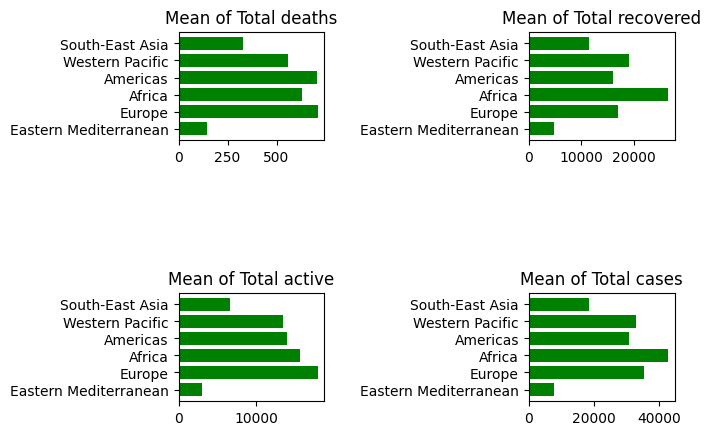

In [29]:
plt.subplot(3,3,1)
plt.barh(who_reg_val,country_wise_df.groupby('WHO Region')['Total deaths'].mean(),color = 'green')
plt.title('Mean of Total deaths')

plt.subplot(3,3,3)
plt.barh(who_reg_val,country_wise_df.groupby('WHO Region')['Total recovered'].mean(),color = 'green')
plt.title('Mean of Total recovered')

plt.subplot(3,3,7)
plt.barh(who_reg_val,country_wise_df.groupby('WHO Region')['Total active'].mean(),color = 'green')
plt.title('Mean of Total active')

plt.subplot(3,3,9)
plt.barh(who_reg_val,country_wise_df.groupby('WHO Region')['Total cases'].mean(),color = 'green')
plt.title('Mean of Total cases')

plt.show()

####  From previous calculations we will find out that highest WHO Region in 

##### 'Total cases' of Covid 19
1. Africa
2. Europe
#####  'Total active'
1. Europe
2. Africa
##### 'Total recovered'
1. Europe
2. Western Pacific
##### 'Total deaths'
1. Europe
2. Americans

In [31]:
#countries =  max_countries_in_active_in_each_who_region.loc[:,'Total recovered']
countries = list(x for x in max_countries_in_active_in_each_who_region["Total recovered"])
countries

['Zimbabwe', 'Venezuela', 'Yemen', 'Uzbekistan', 'Timor-Leste', 'Vietnam']

In [38]:
y = country_wise_df[ country_wise_df['Country/Region'].isin(countries)]

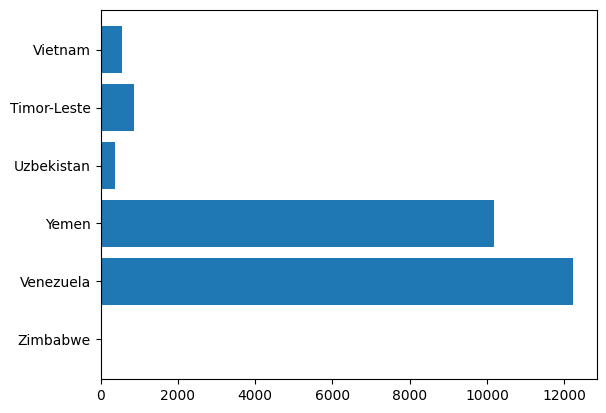

In [40]:
plt.barh(countries, y['Total recovered'])
plt.show()

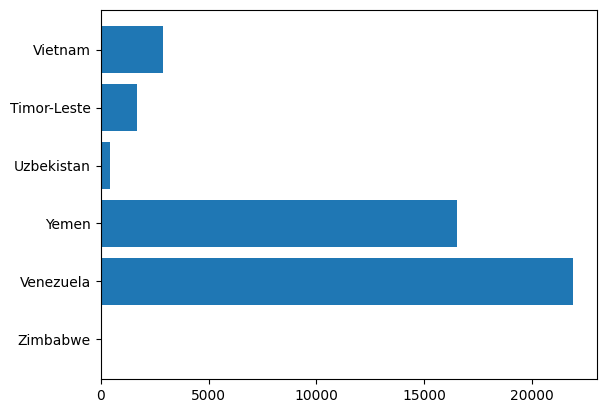

In [42]:
plt.barh(countries, y['Total cases'])
plt.show()

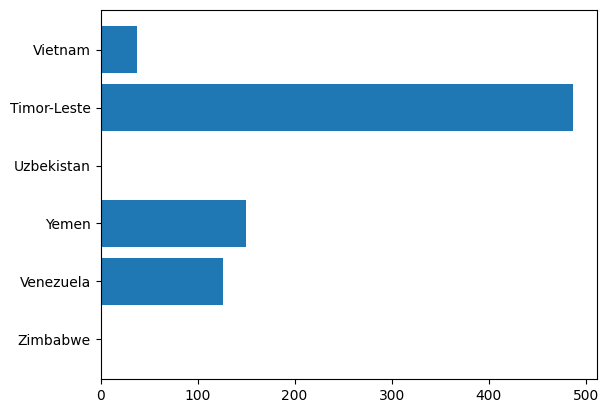

In [44]:
plt.barh(countries, y['Total deaths'])
plt.show()

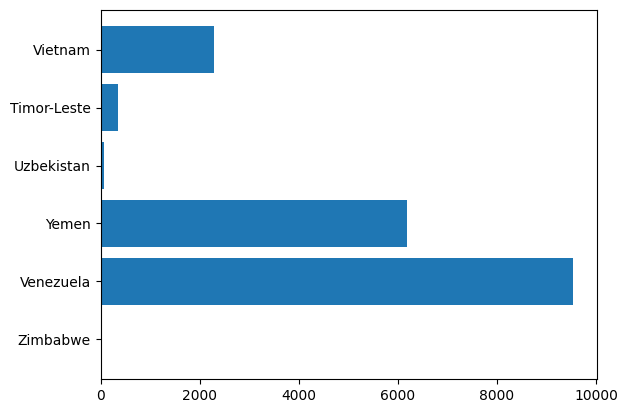

In [45]:
plt.barh(countries, y['Total active'])
plt.show()

#### From the previous analysis we get that for each WHO region has x countries and for the maximum value in each one:
##### for total recovered column
1. Venezuela
2. Yemen
3. Timor-Leste
4. Vietnam
5. Uzbekistan
6. Zimbabwe
##### for total cases column
1. Venezuela
2. Yemen
3. Vietnam
4. Timor-Leste
5. Uzbekistan
6. Zimbabwe
##### for Total deaths column
1. Timor-Leste
2. Yemen
3. Venezuela
4. Vietnam
5. Uzbekistan
6. Zimbabwe
##### for active column
1. Venezuela
2. Yemen
3. Vietnam
4. Timor-Leste
5. Uzbekistan
6. Zimbabwe
